**Step : 1  Upload All Four Source Files**

In [12]:
from google.colab import files
uploaded = files.upload()


Saving ANC4_long.xlsx to ANC4_long.xlsx
Saving WPP2022_GEN_F01_DEMOGRAPHIC_INDICATORS_COMPACT_REV1.xlsx to WPP2022_GEN_F01_DEMOGRAPHIC_INDICATORS_COMPACT_REV1.xlsx
Saving On-track and off-track countries.xlsx to On-track and off-track countries.xlsx
Saving SBA_long.xlsx to SBA_long.xlsx


**Step 2: Load & Clean Population Projections (2022)**

In [13]:
# Load Projections sheet, skipping metadata rows
proj_df = pd.read_excel(
    "WPP2022_GEN_F01_DEMOGRAPHIC_INDICATORS_COMPACT_REV1.xlsx",
    sheet_name="Projections",
    skiprows=16
)

# Filter to 2022, Medium variant, country/area
proj_2022 = proj_df[
    (proj_df['Year'] == 2022) &
    (proj_df['Variant'] == 'Medium') &
    (proj_df['Type'] == 'Country/Area')
][[
    'Region, subregion, country or area *',
    'ISO3 Alpha-code',
    'Births (thousands)'
]].rename(columns={
    'Region, subregion, country or area *': 'Country',
    'ISO3 Alpha-code': 'ISO3',
    'Births (thousands)': 'Births_Thousands'
})

proj_2022['Births'] = proj_2022['Births_Thousands'] * 1000
proj_2022 = proj_2022.dropna(subset=['ISO3'])

display(proj_2022.head())


,Country,ISO3,Births_Thousands,Births
1900,Burundi,BDI,439.648,439648.0
1979,Comoros,COM,24.201,24201.0
2058,Djibouti,DJI,24.549,24549.0
2137,Eritrea,ERI,104.981,104981.0
2216,Ethiopia,ETH,3928.445,3928445.0


**Step 3: Load & Process U5MR Status**

In [14]:
status_df = pd.read_excel("On-track and off-track countries.xlsx")
status_df = status_df.rename(columns={
    'ISO3Code': 'ISO3',
    'OfficialName': 'Country_Name',
    'Status.U5MR': 'U5MR_Status'
})

status_df['Group'] = status_df['U5MR_Status'].str.lower()\
                  .map(lambda x: 'On-track' if x in ['on-track','achieved'] else 'Off-track')


merged_df = proj_2022.merge(status_df[['ISO3','Group']], on='ISO3', how='inner')
display(merged_df.head())


,Country,ISO3,Births_Thousands,Births,Group
0,Burundi,BDI,439.648,439648.0,Off-track
1,Comoros,COM,24.201,24201.0,Off-track
2,Djibouti,DJI,24.549,24549.0,Off-track
3,Eritrea,ERI,104.981,104981.0,Off-track
4,Ethiopia,ETH,3928.445,3928445.0,Off-track


**Step 4: Load & Clean ANC4 and SBA**

In [15]:
def clean_indicator(path, value_name):
    df = pd.read_excel(path, sheet_name="Unicef data")
    df = df[
        (df["Sex"] == "Total") &
        (df["TIME_PERIOD"].between(2018, 2022)) &
        (~df["Geographic area"].str.startswith("("))
    ]
    latest = (df.sort_values("TIME_PERIOD")
               .drop_duplicates("Geographic area", keep="last")
               .loc[:, ["Geographic area", "OBS_VALUE"]]
               .rename(columns={
                   "Geographic area": "Country",
                   "OBS_VALUE": value_name
               }))
    return latest

anc4_latest = clean_indicator("ANC4_long.xlsx", "ANC4")
sba_latest  = clean_indicator("SBA_long.xlsx", "SBA")

display(anc4_latest.head(), sba_latest.head())


,Country,ANC4
76,Cabo Verde,85.6
78,Cameroon,64.9
349,Papua New Guinea,49.0
117,Costa Rica,94.1
301,Montenegro,94.2


,Country,SBA
748,Venezuela (Bolivarian Republic of),98.7
711,Tunisia,99.5
564,Papua New Guinea,56.4
488,Mongolia,99.3
489,Montenegro,98.8


**Step 5: Merge All & Compute Weighted Coverage**

In [16]:
df = merged_df.merge(anc4_latest, on="Country", how="left")\
              .merge(sba_latest,  on="Country", how="left")

for service in ["ANC4","SBA"]:
    for grp in ["On-track","Off-track"]:
        sub = df[df["Group"] == grp]
        wavg = (sub[service] * sub["Births"]).sum() / sub["Births"].sum()
        print(f"{service} ({grp}): {wavg:.1f}%")


ANC4 (On-track): 46.7%
ANC4 (Off-track): 49.9%
SBA (On-track): 60.3%
SBA (Off-track): 67.5%


## **Step 6: Visualize the Results**

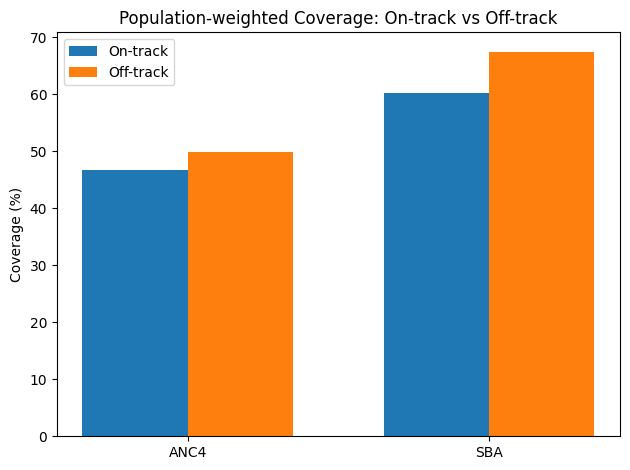

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Services and values
services = ["ANC4", "SBA"]
ontrack = [46.7, 60.3]
offtrack = [49.9, 67.5]

x = np.arange(len(services))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, ontrack, width, label="On-track")
ax.bar(x + width/2, offtrack, width, label="Off-track")

ax.set_xticks(x)
ax.set_xticklabels(services)
ax.set_ylabel("Coverage (%)")
ax.set_title("Population-weighted Coverage: On-track vs Off-track")
ax.legend()

plt.tight_layout()
plt.show()


## Additional Visualizations


**Distribution Boxplots by Group**

* This shows you the spread of country‑level ANC4 and SBA coverages for On‑track vs Off‑track.


/tmp/ipython-input-33-1916463489.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([anc4_on, anc4_off], labels=["On-track","Off-track"])


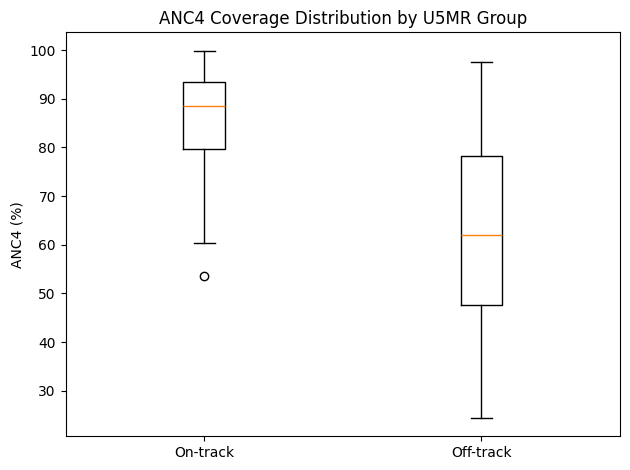

/tmp/ipython-input-33-1916463489.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sba_on, sba_off], labels=["On-track","Off-track"])


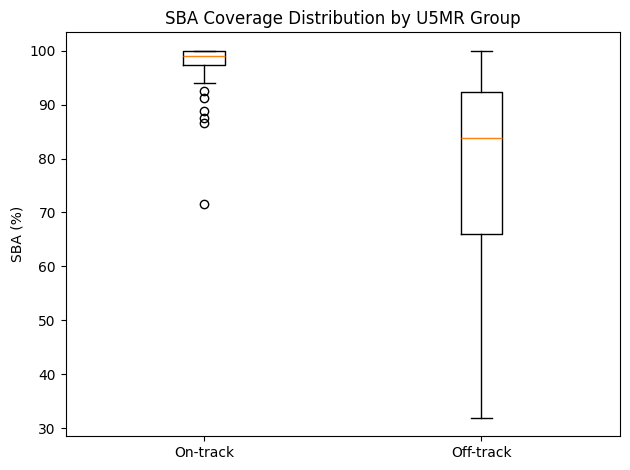

In [33]:
import matplotlib.pyplot as plt

anc4_on  = df.loc[df["Group"]=="On-track",  "ANC4"].dropna()
anc4_off = df.loc[df["Group"]=="Off-track", "ANC4"].dropna()

sba_on   = df.loc[df["Group"]=="On-track",  "SBA"].dropna()
sba_off  = df.loc[df["Group"]=="Off-track", "SBA"].dropna()

# ANC4
plt.figure()
plt.boxplot([anc4_on, anc4_off], labels=["On-track","Off-track"])
plt.title("ANC4 Coverage Distribution by U5MR Group")
plt.ylabel("ANC4 (%)")
plt.tight_layout()
plt.show()

# SBA
plt.figure()
plt.boxplot([sba_on, sba_off], labels=["On-track","Off-track"])
plt.title("SBA Coverage Distribution by U5MR Group")
plt.ylabel("SBA (%)")
plt.tight_layout()
plt.show()


**Scatter of Coverage vs. Births**


*   This helps you see whether country size (birth count) correlates with coverage, colored by group.



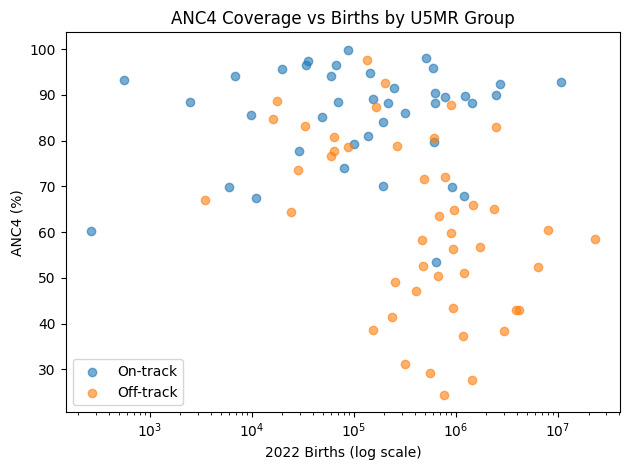

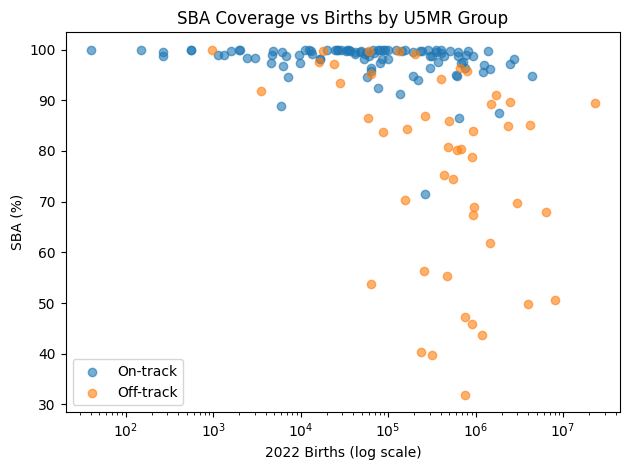

In [34]:
# ANC4
plt.figure()
for grp, color in [("On-track","C0"), ("Off-track","C1")]:
    sub = df[df["Group"]==grp]
    plt.scatter(sub["Births"], sub["ANC4"], label=grp, alpha=0.6)
plt.xscale("log")
plt.xlabel("2022 Births (log scale)")
plt.ylabel("ANC4 (%)")
plt.title("ANC4 Coverage vs Births by U5MR Group")
plt.legend()
plt.tight_layout()
plt.show()

# SBA
plt.figure()
for grp, color in [("On-track","C0"), ("Off-track","C1")]:
    sub = df[df["Group"]==grp]
    plt.scatter(sub["Births"], sub["SBA"], label=grp, alpha=0.6)
plt.xscale("log")
plt.xlabel("2022 Births (log scale)")
plt.ylabel("SBA (%)")
plt.title("SBA Coverage vs Births by U5MR Group")
plt.legend()
plt.tight_layout()
plt.show()


# Interpretation

Population‑weighted ANC4 coverage is slightly higher in off‑track countries (49.9%) than in on‑track ones (46.7%), suggesting that even where under‑five mortality improvements lag, antenatal service uptake remains relatively strong—possibly due to targeted maternal health programs. Conversely, SBA coverage shows a larger gap (67.5% vs. 60.3%), indicating that skilled birth attendance is more consistently available in countries ahead on mortality targets.
**Caveats & Assumptions:**


* We used 2022 medium‑variant birth projections from the UN WPP “Projections” sheet.
*   ANC4/SBA values reflect the most recent data between 2018–2022, which may vary by country in terms of exact year.
*   Country names/ISO3 matching may omit a few small territories if identifiers didn’t align exactly.







In [36]:
# 4) Convert to HTML & PDF
!jupyter nbconvert --to html UNICEF_Assessment.ipynb --output outputs/Report.html

[NbConvertApp] Converting notebook UNICEF_Assessment.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Writing 525878 bytes to outputs/Report.html
